In [1]:
import pandas as pd
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

# 데이터 확인

In [2]:
train_df = pd.read_csv("./data/nsmc/ratings_train.txt", sep = "\t")
test_df = pd.read_csv("./data/nsmc/ratings_test.txt", sep = "\t")

- 0:부정, 1:긍정

In [3]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [6]:
# 결측치 확인
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
# 결측치 확인
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [10]:
train_df = train_df.dropna(subset = ["document"])
test_df = test_df.dropna(subset = ["document"])

In [11]:
train_df.shape, test_df.shape

((149995, 3), (49997, 3))

In [12]:
# 종속변수 확인
np.unique(train_df["label"], return_counts = True)

(array([0, 1], dtype=int64), array([75170, 74825], dtype=int64))

# 데이터 전처리 (예시)

In [13]:
# 한글 이외의 문자들 제거
train_df["document"] = train_df["document"].map(lambda x: re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "", x))
test_df["document"] = test_df["document"].map(lambda x: re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "", x))

In [14]:
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [16]:
train_df = train_df[train_df["document"].map(lambda x: len(x.strip()) >= 1)]
test_df = test_df[test_df["document"].map(lambda x: len(x.strip()) >= 1)]

In [17]:
train_df.shape, test_df.shape

((148740, 3), (49575, 3))

In [18]:
# 중복 데이터 확인
train_df[train_df["document"].duplicated(keep = False)].sort_values("document")

,id,document,label
46599,9682597,그리고 내 감정을 불러 일으켰다,1
43436,9582856,그리고 내 감정을 불러 일으켰다,1
123713,9582855,그리고 내 감정을 불러 일으켰다,1
93364,171409,가입 추천바람,1
138373,171407,가입 추천바람,1
...,...,...,...
57831,3906478,흥미진진,1
8446,5158304,힐러리 더프의 매력에 빠지다,1
72688,5153363,힐러리 더프의 매력에 빠지다,1
26889,7971814,힘들다,0


In [19]:
# 중복 제거
train_df = train_df.drop_duplicates(subset = ["document"], keep = "first")
test_df = test_df.drop_duplicates(subset = ["document"], keep = "first")

In [20]:
train_df.shape, test_df.shape

((143660, 3), (48403, 3))

# 토큰화

In [21]:
okt = Okt()

In [22]:
okt.morphs("아 더빙 진짜 짜증나네요 목소리", stem = False)

['아', '더빙', '진짜', '짜증나네요', '목소리']

In [23]:
okt.morphs("아 더빙 진짜 짜증나네요 목소리", stem = True)

['아', '더빙', '진짜', '짜증나다', '목소리']

In [24]:
okt.nouns("아 더빙 진짜 짜증나네요 목소리")

['더빙', '진짜', '목소리']

In [25]:
okt.pos("아 더빙 진짜 짜증나네요 목소리")

[('아', 'Exclamation'),
 ('더빙', 'Noun'),
 ('진짜', 'Noun'),
 ('짜증나네요', 'Adjective'),
 ('목소리', 'Noun')]

In [38]:
# %%time
# train_df["token"] = train_df["document"].map(lambda x: okt.morphs(x, stem = True))
# test_df["token"] = test_df["document"].map(lambda x: okt.morphs(x, stem = True))

In [26]:
train_df = pd.read_csv("nsmc_ratings_train_pre.csv")
test_df = pd.read_csv("nsmc_ratings_test_pre.csv")

In [27]:
train_df.head()

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"['아', '더빙', '진짜', '짜증나다', '목소리']"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기'..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한',..."
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', ..."
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"['사이', '몬페', '그', '의', '익살스럽다', '연기', '가', '돋보..."


In [28]:
test_df.head()

,id,document,label,token
0,6270596,굳 ㅋ,1,"['굳다', 'ㅋ']"
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"['뭐', '야', '이', '평점', '들', '은', '나쁘다', '않다', '..."
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기..."
3,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '..."
4,7898805,음악이 주가 된 최고의 음악영화,1,"['음악', '이', '주가', '되다', '최고', '의', '음악', '영화']"


In [29]:
type(train_df.loc[0, "token"])

str

In [30]:
# 혹시 문자열로 읽히면 리스트타입으로 바꾸는 법
train_df["token"] = train_df["token"].map(lambda x: eval(x))
test_df["token"] = test_df["token"].map(lambda x: eval(x))

In [31]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

In [32]:
# # 공백 제거
# train_df["token"] = train_df["token"].map(lambda x: [i for i in x if len(i) > 1])
# test_df["token"] = test_df["token"].map(lambda x: [i for i in x if len(i) > 1])

In [32]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

In [33]:
train_df.head()

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."


In [34]:
# 내용이 없는 데이터 제거
train_df = train_df[train_df["token"].map(lambda x: len(x) > 0)]
test_df = test_df[test_df["token"].map(lambda x: len(x) > 0)]

In [35]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

# 불용어 리스트 제거하기

In [37]:
# 불용어 정의 = 빈도수 TOP 500 중 불필요한 형태소 정리
stopword = ["에서", "으로", "이고", "에게", "라는", "지만", "인가", "이네", "그래도", "하다", "에는", "이랑", "이라", "내내", "밖에", "이라는", "한테", "이지", "에도", "위해", "이라고", "아무", "이야", "이지만", "니까", "그저", "대해", "건가",  "어디", "이후", "그래서", "누구", "이리", "어느", "여기", "자기", "해도", "분들", "그런", "다음", "라도", "만큼", "이라도", "동안", "이다", "하고", "정도", "인데"]

In [43]:
x_train = []

for s in train_df["document"]:
    temp_x = okt.morphs(s, stem = True)
    temp_x = [word for word in temp_x if not word in stopword]
    x_train.append(temp_x)

In [45]:
x_test = []

for s in test_df["document"]:
    temp_x = okt.morphs(s, stem = True)
    temp_x = [word for word in temp_x if not word in stopword]
    x_test.append(temp_x)

In [46]:
x_train[:5]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '의',
  '익살스럽다',
  '연기',
  '가',
  '돋보이다',
  '영화',
  '스파이더맨',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '가',
  '너무나도',
  '이쁘다',
  '보이다']]

# 정수인코딩

In [36]:
tokenizer = Tokenizer() # num_words 설정을 여기서함
# num_words를 설정할 때는 높을수록 모델이 훈련을 잘 하긴 함. 그러니 과대적합이 일어날 가능성이 있음

In [37]:
# 단어 집합 생성
# 등장 빈도 수가 높은 순서대로 정수값 부여
tokenizer.fit_on_texts(train_df["token"])

In [38]:
tokenizer.word_index

{'이': 1,
 '영화': 2,
 '보다': 3,
 '하다': 4,
 '의': 5,
 '에': 6,
 '가': 7,
 '을': 8,
 '도': 9,
 '들': 10,
 '는': 11,
 '를': 12,
 '은': 13,
 '없다': 14,
 '이다': 15,
 '있다': 16,
 '좋다': 17,
 '너무': 18,
 '다': 19,
 '정말': 20,
 '한': 21,
 '되다': 22,
 '적': 23,
 '만': 24,
 '재밌다': 25,
 '같다': 26,
 '진짜': 27,
 '으로': 28,
 '로': 29,
 '아니다': 30,
 '않다': 31,
 '점': 32,
 '에서': 33,
 '만들다': 34,
 '과': 35,
 '나오다': 36,
 '연기': 37,
 '것': 38,
 '평점': 39,
 '내': 40,
 '최고': 41,
 '그': 42,
 '나': 43,
 '안': 44,
 '인': 45,
 '스토리': 46,
 '생각': 47,
 '못': 48,
 '왜': 49,
 '드라마': 50,
 '게': 51,
 '사람': 52,
 '감동': 53,
 '보고': 54,
 '이렇다': 55,
 '고': 56,
 '말': 57,
 '아깝다': 58,
 '더': 59,
 '배우': 60,
 '때': 61,
 'ㅋㅋ': 62,
 '와': 63,
 '아': 64,
 '감독': 65,
 '거': 66,
 '그냥': 67,
 '요': 68,
 '재미있다': 69,
 '재미': 70,
 '시간': 71,
 '내용': 72,
 '까지': 73,
 '뭐': 74,
 '중': 75,
 '주다': 76,
 '좀': 77,
 '자다': 78,
 '하고': 79,
 '지루하다': 80,
 '수': 81,
 '재미없다': 82,
 '네': 83,
 '쓰레기': 84,
 '모르다': 85,
 '가다': 86,
 '들다': 87,
 '그렇다': 88,
 '싶다': 89,
 '지': 90,
 '작품': 91,
 '사랑': 92,
 '알다': 93,
 '하나': 94

In [39]:
# 단어 등장 수
type(tokenizer.word_counts)

collections.OrderedDict

In [40]:
total_cnt = len(tokenizer.word_index)
total_cnt

43770

# 0419수업 풀이

In [68]:
# 사용 단어 수를 지정하여 토큰화
tokenizer = Tokenizer(num_words = 30000)
tokenizer.fit_on_texts(train_df["token"])

In [69]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

In [70]:
print("단어 집합의 크기", total_cnt)
print("등장 빈도가 %d번 이하인 회귀 단어의 수: %d" % (threshold-1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합의 크기 43770
등장 빈도가 2번 이하인 회귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.608864519076995
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5747898974035586


In [71]:
x_train = tokenizer.texts_to_sequences(train_df["token"])
x_test = tokenizer.texts_to_sequences(test_df["token"])

In [72]:
x_train

[[64, 473, 27, 278, 677],
 [965, 474, 54, 620, 2, 230, 1466, 37, 979, 694, 31],
 [403, 2460, 25033, 2330, 5684, 3, 237, 21, 19],
 [6507, 120, 8133, 234, 70, 11, 14, 39, 3619],
 [1041,
  19431,
  42,
  5,
  9158,
  37,
  7,
  849,
  2,
  2592,
  33,
  1126,
  256,
  4,
  14255,
  19432,
  7,
  1092,
  270,
  256],
 [739,
  5685,
  998,
  1405,
  443,
  159,
  1707,
  1640,
  11578,
  241,
  2,
  108,
  142,
  1109,
  9,
  58,
  261],
 [229, 5, 331, 8, 341, 503, 4],
 [142,
  1109,
  9,
  58,
  349,
  36,
  9801,
  14256,
  315,
  138,
  1600,
  1,
  385,
  135,
  242,
  20,
  817,
  29,
  597,
  592,
  536,
  493,
  3134,
  8134,
  24,
  1406,
  1406,
  1,
  50,
  11,
  301,
  9,
  14,
  37,
  48,
  4,
  52,
  24,
  721,
  1090,
  83],
 [110, 1, 14, 70, 16, 385, 113, 2],
 [1548, 39, 1, 217, 554, 97, 24, 21, 410, 1457, 378, 683, 18, 5686, 16],
 [399, 4704, 7, 183, 15, 27, 183, 15],
 [759,
  401,
  1243,
  220,
  389,
  5,
  2543,
  306,
  357,
  11579,
  11,
  621,
  2512,
  825,
  5,
  5

In [73]:
y_train = np.array(train_df["label"]) # = train_df["label"].values
y_test = np.array(test_df["label"]) # = test_df["label"].values

In [74]:
length = np.array([len(x) for x in x_train])

In [75]:
print(np.mean(length), np.min(length), np.median(length), np.max(length))

13.13909230126688 0 10.0 75


# 모델

In [76]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,
                                                 random_state = 42)

In [77]:
train_seq = pad_sequences(x_train, maxlen = 80)
val_seq = pad_sequences(x_val, maxlen = 80)
test_seq = pad_sequences(x_test, maxlen = 80)

In [79]:
model = keras.Sequential()
model.add(keras.layers.Embedding(30000, 100, input_shape = (80,)))
model.add(keras.layers.LSTM(128, dropout = 0.4, return_sequences = True))
model.add(keras.layers.LSTM(128, dropout = 0.4))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

In [80]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 80, 100)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 80, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,248,961 (12.39 MB)

 Trainable params: 3,248,961 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
adam = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [85]:
history = model.fit(train_seq, y_train, epochs = 100, batch_size = 128,
                   validation_data = (val_seq, y_val),
                   callbacks = [early_stopping_cb])

Epoch 1/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 167s 181ms/step - accuracy: 0.7875 - loss: 0.4420 - val_accuracy: 0.8499 - val_loss: 0.3373
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 163s 181ms/step - accuracy: 0.8832 - loss: 0.2818 - val_accuracy: 0.8498 - val_loss: 0.3433
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 166s 185ms/step - accuracy: 0.9060 - loss: 0.2315 - val_accuracy: 0.8488 - val_loss: 0.3882
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 154s 172ms/step - accuracy: 0.9207 - loss: 0.1960 - val_accuracy: 0.8450 - val_loss: 0.4045


In [86]:
model.evaluate(test_seq, y_test)

1513/1513 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.8506 - loss: 0.3369


[0.34115010499954224, 0.8490176200866699]

In [87]:
def sent_predict(text):
    text = re.sub(r"[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "", text)
    text = okt.morphs(text, stem = True)
    encoded = tokenizer.texts_to_sequences([text])
    pad_new = pad_sequences(encoded, maxlen = 80)
    score = model.predict(pad_new)
    
    return score

In [88]:
sent_predict("잘도 그러겠다")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


array([[0.5217607]], dtype=float32)

In [92]:
sent_predict("엿 같고 참 좋아요")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[0.85943407]], dtype=float32)

In [90]:
sent_predict("시간낭비하기 좋아요")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.04999371]], dtype=float32)

In [91]:
sent_predict("돈 낭비는 즐거워")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.12165435]], dtype=float32)

In [55]:
train_df.head()

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."


In [56]:
test_df.head()

,id,document,label,token
0,6270596,굳 ㅋ,1,"[굳다, ㅋ]"
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"[뭐, 야, 이, 평점, 들, 은, 나쁘다, 않다, 점, 짜다, 리, 는, 더, 더..."
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[지루하다, 않다, 완전, 막장, 임, 돈, 주다, 보기, 에는]"
3,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"[만, 아니다, 별, 다섯, 개, 주다, 왜, 로, 나오다, 제, 심기, 를, 불편..."
4,7898805,음악이 주가 된 최고의 음악영화,1,"[음악, 이, 주가, 되다, 최고, 의, 음악, 영화]"


# 리뷰의 길이 확인

In [56]:
lengths = np.array([len(x) for x in x_train])

In [57]:
# 길이 평균값과 중간값, 최소값, 최댓값
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))

9.029054068197517 7.0 1 67


- 평균 9.03
- 중앙값 7
- 최소값 1
- 최댓값 67

- maxlen값을 최댓값의 절반인 33으로 설정

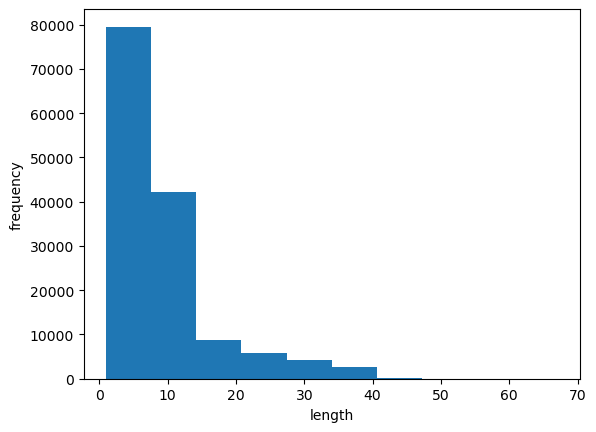

In [58]:
plt.figure()

plt.hist(lengths)

plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

# 데이터 나누기

In [59]:
# y_train, y_test 나누기
y_train = np.array(train_df["label"])
y_test = np.array(test_df["label"])

In [60]:
# 훈련 세트와 검증 세트로 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,
                                                 stratify=y_train, random_state = 42)

In [65]:
len(x_train), len(x_test), len(x_val)

(114655, 48260, 28664)

In [64]:
y_train.shape, y_val.shape

((114655,), (28664,))

In [66]:
len(x_train[1])

12

In [67]:
# 로이터 뉴스와 같이 생각하면 truncating을 post로 둬보자
# 너무 짧은 문장에서는 truncating을 사용할 필요가 없음
# 너무 짧은 문장이라면 리뷰 .. 같은 것들은 maxlen을 최댓값의 90% ~ 100% 사이로 지정하는 것이 좋음
train_seq = pad_sequences(x_train, maxlen = 33, truncating = "post")
val_seq = pad_sequences(x_val, maxlen = 33, truncating = "post")
test_seq = pad_sequences(x_test, maxlen = 33, truncating = "post")

In [68]:
# train_seq 크기 확인
print(train_seq.shape)

(114655, 30)


In [69]:
print(train_seq[0])

[ 149   21 1169   30  277  102  269 1687 1551  555 1799  292  395  132
  277 4555  652  306  523  565 4555 5849   93  201 9352    3  234 1095
  515  652]


In [72]:
# 패딩 확인
train_seq[0]

array([ 149,   21, 1169,   30,  277,  102,  269, 1687, 1551,  555, 1799,
        292,  395,  132,  277, 4555,  652,  306,  523,  565, 4555, 5849,
         93,  201, 9352,    3,  234, 1095,  515,  652])

# 모델 구성

- RNN + CNN

In [78]:
model = keras.Sequential()

model.add(keras.layers.Embedding(1000, 128, input_shape=(33,)))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv1D(64, 5, activation = "relu"))
model.add(keras.layers.MaxPool1D(4))
model.add(keras.layers.LSTM(64, dropout = 0.5, return_sequences = True))
model.add(keras.layers.LSTM(32))

model.add(keras.layers.Dense(1, activation = "sigmoid"))

In [79]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 33, 128)             │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 33, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 29, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,497 (837.88 KB)

 Trainable params: 214,497 (837.88 KB)

 Non-trainable params: 0 (0.00 B)

# 모델 훈련

In [80]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-cnnrnn-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [81]:
history = model.fit(train_seq, y_train, epochs = 100, batch_size = 32,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5937 - loss: 0.6353 - val_accuracy: 0.7195 - val_loss: 0.5285
Epoch 2/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7234 - loss: 0.5245 - val_accuracy: 0.7253 - val_loss: 0.5180
Epoch 3/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7294 - loss: 0.5172 - val_accuracy: 0.7267 - val_loss: 0.5209
Epoch 4/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7303 - loss: 0.5145 - val_accuracy: 0.7260 - val_loss: 0.5163
Epoch 5/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7339 - loss: 0.5102 - val_accuracy: 0.7277 - val_loss: 0.5145
Epoch 6/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7325 - loss: 0.5104 - val_accuracy: 0.7268 - val_loss: 0.5145
Epoch 7/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7309 - loss: 0.5092 - val_accuracy: 0.7290 - val_loss: 0.5132
Epoch 8/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7340 -

In [82]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7237 - loss: 0.5171


[0.5151687860488892, 0.7261500358581543]

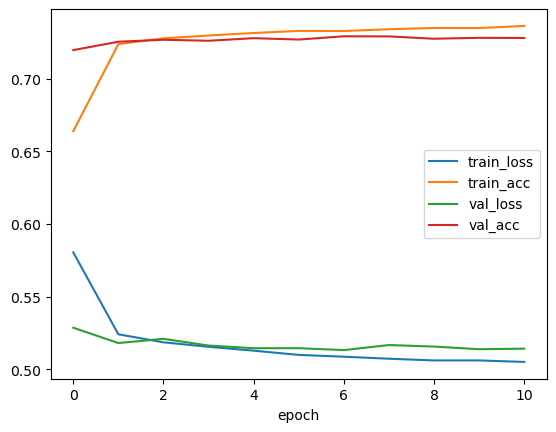

In [83]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model1-2

In [84]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.005)
model.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-cnnrnn-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [85]:
history = model.fit(train_seq, y_train, epochs = 100, batch_size = 16,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7216 - loss: 0.5303 - val_accuracy: 0.7203 - val_loss: 0.5444
Epoch 2/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.7177 - loss: 0.5382 - val_accuracy: 0.7198 - val_loss: 0.5586
Epoch 3/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7246 - loss: 0.5363 - val_accuracy: 0.7193 - val_loss: 0.5430
Epoch 4/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7222 - loss: 0.5409 - val_accuracy: 0.7208 - val_loss: 0.5513
Epoch 5/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7249 - loss: 0.5390 - val_accuracy: 0.7101 - val_loss: 0.5502
Epoch 6/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7237 - loss: 0.5399 - val_accuracy: 0.7193 - val_loss: 0.5450
Epoch 7/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.7250 - loss: 0.5375 - val_accuracy: 0.7207 - val_loss: 0.5547
Epoch 8/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7242 -

In [86]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7184 - loss: 0.5429


[0.5428904891014099, 0.7197679281234741]

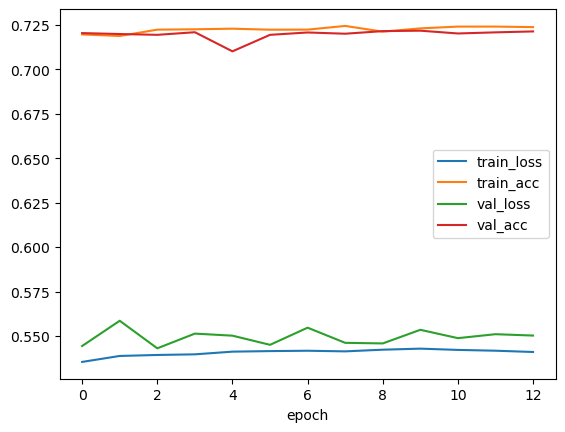

In [87]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model1-3

In [88]:
history = model.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7258 - loss: 0.5306 - val_accuracy: 0.7251 - val_loss: 0.5463
Epoch 2/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7280 - loss: 0.5292 - val_accuracy: 0.7232 - val_loss: 0.5407
Epoch 3/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7263 - loss: 0.5283 - val_accuracy: 0.7245 - val_loss: 0.5328
Epoch 4/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7277 - loss: 0.5244 - val_accuracy: 0.7249 - val_loss: 0.5334
Epoch 5/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7237 - loss: 0.5295 - val_accuracy: 0.7114 - val_loss: 0.5438
Epoch 6/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7264 - loss: 0.5272 - val_accuracy: 0.7213 - val_loss: 0.5332
Epoch 7/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7296 - loss: 0.5278 - val_accuracy: 0.7101 - val_loss: 0.5378
Epoch 8/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7271 -

In [89]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7194 - loss: 0.5358


[0.5347972512245178, 0.7211354970932007]

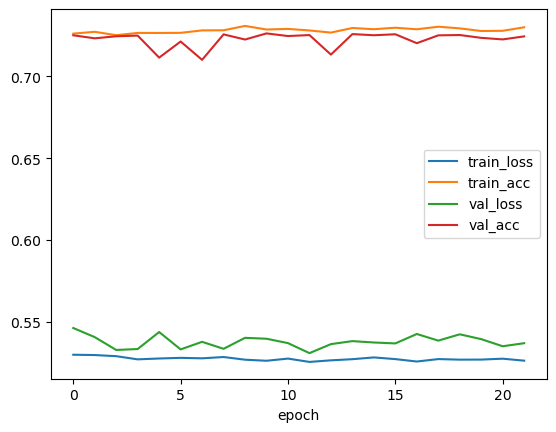

In [90]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model2-1

In [96]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model2.add(keras.layers.LSTM(128))

model2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [99]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.005)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [100]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7600 - loss: 0.4825 - val_accuracy: 0.7850 - val_loss: 0.4352
Epoch 2/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7867 - loss: 0.4314 - val_accuracy: 0.7913 - val_loss: 0.4282
Epoch 3/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7951 - loss: 0.4177 - val_accuracy: 0.7934 - val_loss: 0.4239
Epoch 4/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.7990 - loss: 0.4115 - val_accuracy: 0.7957 - val_loss: 0.4184
Epoch 5/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8046 - loss: 0.4044 - val_accuracy: 0.7912 - val_loss: 0.4266
Epoch 6/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8052 - loss: 0.4001 - val_accuracy: 0.7925 - val_loss: 0.4261
Epoch 7/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8094 - loss: 0.3933 - val_accuracy: 0.7967 - val_loss: 0.4195
Epoch 8/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 

In [103]:
model2.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7932 - loss: 0.4167


[0.41900748014450073, 0.7932242155075073]

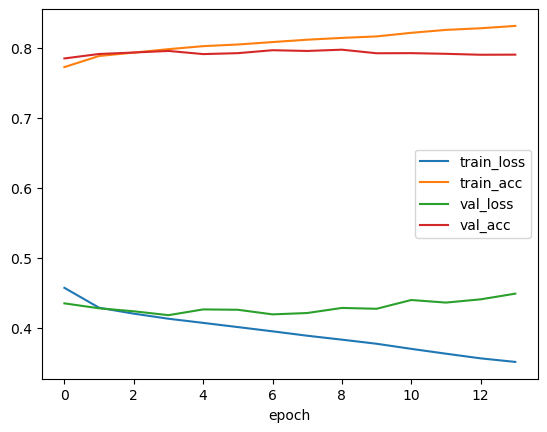

In [104]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model2-2

In [105]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [106]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 32,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.8065 - loss: 0.3971 - val_accuracy: 0.7963 - val_loss: 0.4181
Epoch 2/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8074 - loss: 0.3921 - val_accuracy: 0.7947 - val_loss: 0.4196
Epoch 3/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.8110 - loss: 0.3901 - val_accuracy: 0.7975 - val_loss: 0.4171
Epoch 4/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8154 - loss: 0.3827 - val_accuracy: 0.7948 - val_loss: 0.4216
Epoch 5/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.8130 - loss: 0.3829 - val_accuracy: 0.7975 - val_loss: 0.4217
Epoch 6/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8179 - loss: 0.3747 - val_accuracy: 0.7943 - val_loss: 0.4253
Epoch 7/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8215 - loss: 0.3676 - val_accuracy: 0.7950 - val_loss: 0.4309
Epoch 8/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 

In [107]:
model2.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7947 - loss: 0.4161


[0.4185965359210968, 0.7941773533821106]

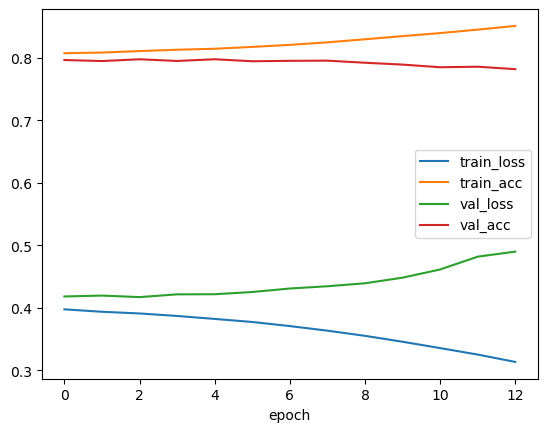

In [108]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model2-3

In [109]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 32, input_shape = (33,)))
model2.add(keras.layers.LSTM(128))

model2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [110]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.005)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [111]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.7336 - loss: 0.5168 - val_accuracy: 0.7790 - val_loss: 0.4412
Epoch 2/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7864 - loss: 0.4313 - val_accuracy: 0.7894 - val_loss: 0.4300
Epoch 3/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7965 - loss: 0.4175 - val_accuracy: 0.7918 - val_loss: 0.4245
Epoch 4/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7960 - loss: 0.4160 - val_accuracy: 0.7948 - val_loss: 0.4206
Epoch 5/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8009 - loss: 0.4066 - val_accuracy: 0.7950 - val_loss: 0.4203
Epoch 6/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.8068 - loss: 0.3993 - val_accuracy: 0.7973 - val_loss: 0.4180
Epoch 7/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8073 - loss: 0.3975 - val_accuracy: 0.7981 - val_loss: 0.4206
Epoch 8/100
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 

In [112]:
model2.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7931 - loss: 0.4183


[0.41909703612327576, 0.794343113899231]

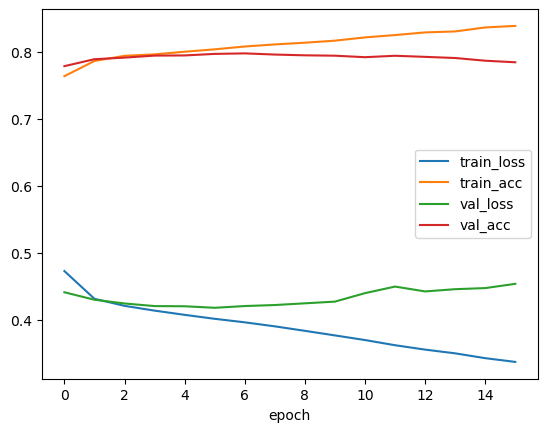

In [113]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model2-4

In [122]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model2.add(keras.layers.LSTM(128))

model2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [123]:
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,561 (385.00 KB)

 Trainable params: 98,561 (385.00 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [125]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 16,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.7374 - loss: 0.5060 - val_accuracy: 0.7823 - val_loss: 0.4456
Epoch 2/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.7815 - loss: 0.4432 - val_accuracy: 0.7875 - val_loss: 0.4327
Epoch 3/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.7866 - loss: 0.4328 - val_accuracy: 0.7870 - val_loss: 0.4320
Epoch 4/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.7917 - loss: 0.4258 - val_accuracy: 0.7902 - val_loss: 0.4296
Epoch 5/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.7902 - loss: 0.4264 - val_accuracy: 0.7896 - val_loss: 0.4275
Epoch 6/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.7984 - loss: 0.4146 - val_accuracy: 0.7934 - val_loss: 0.4249
Epoch 7/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.7960 - loss: 0.4157 - val_accuracy: 0.7935 - val_loss: 0.4254
Epoch 8/100
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.8003 -

In [126]:
model2.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7912 - loss: 0.4251


[0.4258081912994385, 0.7922917604446411]

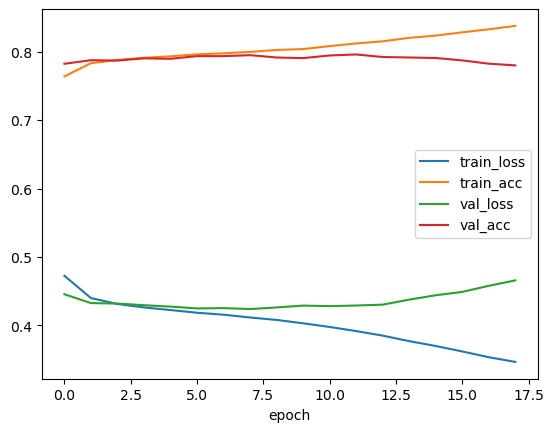

In [127]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model3

In [114]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.LSTM(128, dropout = 0.3, return_sequences = True))
model3.add(keras.layers.LSTM(64))

model3.add(keras.layers.Dense(1, activation = "sigmoid"))

In [116]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,033 (578.25 KB)

 Trainable params: 147,969 (578.00 KB)

 Non-trainable params: 64 (256.00 B)

In [117]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model3.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [119]:
history = model3.fit(train_seq, y_train, epochs = 100, batch_size = 32,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.7421 - loss: 0.4989 - val_accuracy: 0.7835 - val_loss: 0.4368
Epoch 2/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - accuracy: 0.7822 - loss: 0.4392 - val_accuracy: 0.7896 - val_loss: 0.4321
Epoch 3/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.7909 - loss: 0.4267 - val_accuracy: 0.7924 - val_loss: 0.4241
Epoch 4/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - accuracy: 0.7920 - loss: 0.4231 - val_accuracy: 0.7896 - val_loss: 0.4235
Epoch 5/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.7916 - loss: 0.4209 - val_accuracy: 0.7947 - val_loss: 0.4248
Epoch 6/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.7936 - loss: 0.4218 - val_accuracy: 0.7945 - val_loss: 0.4238
Epoch 7/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - accuracy: 0.7964 - loss: 0.4146 - val_accuracy: 0.7952 - val_loss: 0.4228
Epoch 8/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 

In [120]:
model3.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7957 - loss: 0.4154


[0.4171617329120636, 0.7955864071846008]

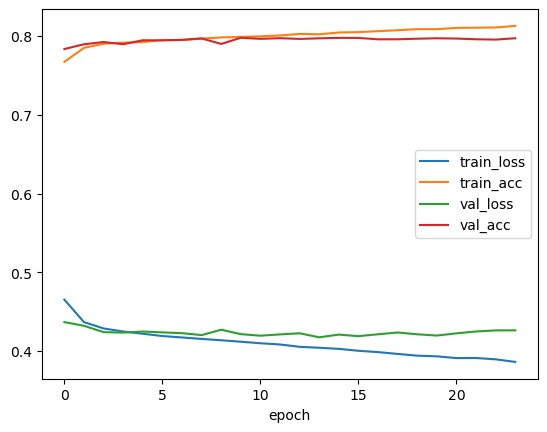

In [121]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model4

In [128]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.LSTM(64))

model4.add(keras.layers.Dense(1, activation = "sigmoid"))

In [129]:
model4.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,025 (160.25 KB)

 Trainable params: 40,961 (160.00 KB)

 Non-trainable params: 64 (256.00 B)

In [130]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model4.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [131]:
history = model4.fit(train_seq, y_train, epochs = 100, batch_size = 32,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.7547 - loss: 0.4813 - val_accuracy: 0.7903 - val_loss: 0.4287
Epoch 2/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7904 - loss: 0.4242 - val_accuracy: 0.7956 - val_loss: 0.4195
Epoch 3/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8001 - loss: 0.4126 - val_accuracy: 0.7959 - val_loss: 0.4201
Epoch 4/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8031 - loss: 0.4036 - val_accuracy: 0.7979 - val_loss: 0.4167
Epoch 5/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8074 - loss: 0.3979 - val_accuracy: 0.7989 - val_loss: 0.4171
Epoch 6/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8090 - loss: 0.3931 - val_accuracy: 0.7978 - val_loss: 0.4182
Epoch 7/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8115 - loss: 0.3891 - val_accuracy: 0.7973 - val_loss: 0.4171
Epoch 8/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8128 -

In [132]:
model4.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7950 - loss: 0.4154


[0.41766995191574097, 0.7959386706352234]

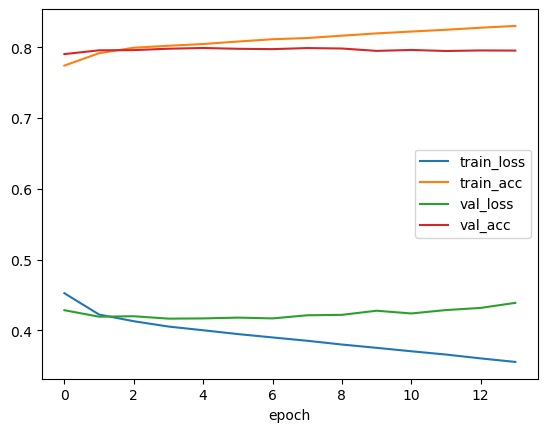

In [133]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# Model 5

In [134]:
model5 = keras.Sequential()

model5.add(keras.layers.Embedding(5000, 32, input_shape = (33,)))
model5.add(keras.layers.GRU(64))

model5.add(keras.layers.Dense(1, activation = "sigmoid"))

In [135]:
model5.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 33, 32)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,881 (698.75 KB)

 Trainable params: 178,881 (698.75 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model5.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-gru-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [137]:
history = model5.fit(train_seq, y_train, epochs = 100, batch_size = 32,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.7609 - loss: 0.4776 - val_accuracy: 0.8229 - val_loss: 0.3882
Epoch 2/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8305 - loss: 0.3760 - val_accuracy: 0.8297 - val_loss: 0.3756
Epoch 3/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8396 - loss: 0.3592 - val_accuracy: 0.8361 - val_loss: 0.3676
Epoch 4/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.8475 - loss: 0.3444 - val_accuracy: 0.8357 - val_loss: 0.3657
Epoch 5/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8533 - loss: 0.3328 - val_accuracy: 0.8370 - val_loss: 0.3636
Epoch 6/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8578 - loss: 0.3241 - val_accuracy: 0.8337 - val_loss: 0.3695
Epoch 7/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8629 - loss: 0.3157 - val_accuracy: 0.8391 - val_loss: 0.3599
Epoch 8/100
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8657 -

In [138]:
model5.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8375 - loss: 0.3619


[0.36576277017593384, 0.8369457125663757]

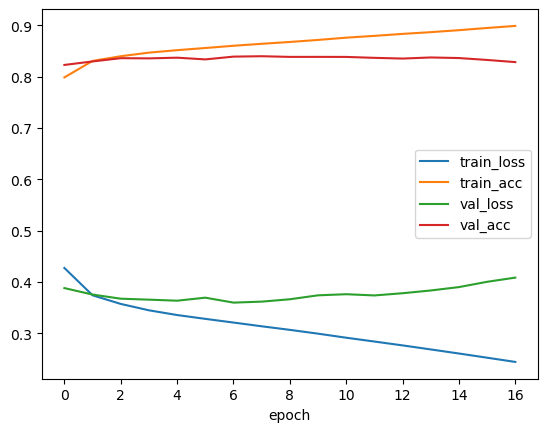

In [139]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()